In [6]:
# import onnx
import torch
# import onnxruntime as ort
# import tensorrt as trt
# import torchtext

# print('torchText:', torchtext.__version__)
# print("trt Version: ", trt.__version__)
print("CUDA Version: ", torch.version.cuda)
print("CuDNN Version: ", torch.backends.cudnn.version())
print("torch Version: ", torch.__version__)
# print("onnx Version: ", onnx.__version__)
# print("ort Version: ", ort.__version__)
# 检查是否加载了 GPU 版本
# providers = ort.get_available_providers()
# print("Available providers:", providers)

CUDA Version:  11.7
CuDNN Version:  8500
torch Version:  1.13.0


In [10]:
import torch
from torch.quantization.observer import MinMaxObserver, MovingAverageMinMaxObserver, HistogramObserver
C, L = 2, 2
normal = torch.distributions.normal.Normal(0,1)
inputs = [normal.sample((C, L)), normal.sample((C, L))]
print(inputs)

observers = [MinMaxObserver(), MovingAverageMinMaxObserver(), HistogramObserver()]
for obs in observers:
  for x in inputs: 
    obs(x) 
    print(obs.__class__.__name__, obs.calculate_qparams())

[tensor([[ 0.9330, -0.7461],
        [-0.5724,  0.2623]]), tensor([[-0.8825,  1.6841],
        [ 0.3868,  0.8927]])]
MinMaxObserver (tensor([0.0066]), tensor([113], dtype=torch.int32))
MinMaxObserver (tensor([0.0101]), tensor([88], dtype=torch.int32))
MovingAverageMinMaxObserver (tensor([0.0066]), tensor([113], dtype=torch.int32))
MovingAverageMinMaxObserver (tensor([0.0066]), tensor([113], dtype=torch.int32))
HistogramObserver (tensor([0.0066]), tensor([113], dtype=torch.int32))
HistogramObserver (tensor([0.0090]), tensor([98], dtype=torch.int32))


<Figure size 1280x960 with 0 Axes>

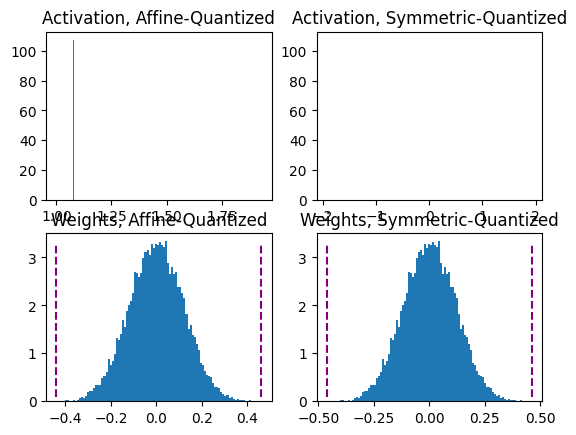

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

act =  torch.distributions.pareto.Pareto(1, 10).sample((1,1024))
weights = torch.distributions.normal.Normal(0, 0.12).sample((3, 64, 7, 7)).flatten()

def get_symmetric_range(x):
    beta = torch.max(x.max(), x.min().abs())
    return -beta.item(), beta.item()

def get_affine_range(x):
    return x.min().item(), x.max().item()

def plot(plt, data, scheme):
    boundaries = get_affine_range(data) if scheme == 'affine' else get_symmetric_range(data)
    a, _, _ = plt.hist(data, density=True, bins=100)
    ymin, ymax = np.quantile(a[a>0], [0.25, 0.95])
    plt.vlines(x=boundaries, ls='--', colors='purple', ymin=ymin, ymax=ymax)

plt.figure(dpi=200)
fig, axs = plt.subplots(2,2)
plot(axs[0, 0], act, 'affine')
axs[0, 0].set_title("Activation, Affine-Quantized")

plot(axs[0, 1], act, 'symmetric')
axs[0, 1].set_title("Activation, Symmetric-Quantized")

plot(axs[1, 0], weights, 'affine')
axs[1, 0].set_title("Weights, Affine-Quantized")

plot(axs[1, 1], weights, 'symmetric')
axs[1, 1].set_title("Weights, Symmetric-Quantized")
plt.show()

In [18]:
import torch
from torch.quantization.observer import MinMaxObserver, MovingAverageMinMaxObserver, HistogramObserver
torch.manual_seed(1)
# C, L = 3, 4
# normal = torch.distributions.normal.Normal(0,1)
# inputs = [normal.sample((C, L)), normal.sample((C, L))]
rand_tensor = torch.randint(-255, 256, (3, 4))
print(rand_tensor)
inputs = [rand_tensor]
for qscheme in [torch.per_tensor_affine, torch.per_tensor_symmetric]:
  obs = MinMaxObserver(qscheme=qscheme)
  for x in inputs: obs(x)
  print(f"Qscheme: {qscheme} | {obs.calculate_qparams()}")

tensor([[ 221,  -98,   85, -224],
        [ -63, -221,    4,   37],
        [ 158,   14, -195,   24]])
Qscheme: torch.per_tensor_affine | (tensor([1.7451]), tensor([128], dtype=torch.int32))
Qscheme: torch.per_tensor_symmetric | (tensor([1.7569]), tensor([128]))


In [ ]:
import inspect
import torch

def log(*msg):
    stack = inspect.stack()
    print(stack)
log("11", "22", torch.tensor([0.0]), torch.tensor([0.0]).shape)


In [21]:
from torchvision import datasets
from torch.utils.data import DataLoader

# 加载 ImageNet 验证集
imagenet_data = datasets.ImageNet(root="model_deploy/data", split='val')
data_loader = DataLoader(imagenet_data, batch_size=32, shuffle=False)

RuntimeError: The archive ILSVRC2012_devkit_t12.tar.gz is not present in the root directory or is corrupted. You need to download it externally and place it in model_deploy/data.